# Sliding Window 
Feb 2019

Regression based grasp predictor
* Input is black and white image
* Net is 2 conv layers, 3 FC layers
* Output is x,y, theta of grasp

In [1]:
from PIL import Image, ImageDraw
%matplotlib inline
import numpy as np

import torch
import torch.nn as nn
from skimage import io
import math

from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import cv2
import matplotlib.pyplot as plt

import time
import os
import copy 


In [2]:
IMG_X, IMG_Y = 200,200 
# length and width of blocks (fixed for now)
block_l, block_w = 20, 30


# Make dataset -------------------------------------------------------

def makeRectangle(l, w, theta, offset=(0, 0)):
    c, s = math.cos(theta), math.sin(theta)
    rectCoords = [(l/2.0, w/2.0), (l/2.0, -w/2.0),
                  (-l/2.0, -w/2.0), (-l/2.0, w/2.0)]
    return [(c*x-s*y+offset[0], s*x+c*y+offset[1]) for (x, y) in rectCoords]


# ---- Make depth images ---
def make_dataset(dirname, num_images):
    true_coords = []
    newpath = './' + dirname
    if not os.path.exists(newpath):
        os.makedirs(newpath)
        print(newpath)
    for i in range(num_images):
        # orient = 0 # degrees
        img = Image.new('RGB', (IMG_X, IMG_Y), 'black')

        # block_l and _w offset so blocks don't run off edge of image
        rand_x = int(np.random.rand() * (IMG_X-2*block_l)) + block_l
        rand_y = int(np.random.rand() * (IMG_Y-2*block_w)) + block_w
        orient = int(np.random.rand() * 180)  # .random() is range [0.0, 1.0).
        orient = math.radians(orient)  # math.cos takes radians!

        true_coords.append(np.array((rand_x, rand_y, orient)))

        rect_vertices = makeRectangle(block_l, block_w, orient, offset=(rand_x,
                                                                        rand_y))

        idraw = ImageDraw.Draw(img)
        idraw.polygon(rect_vertices, fill='white')

        # use a truetype font
        # font = imagefont.truetype("dejavusans.ttf", 15)
        # font = imagefont.truetype("arial.ttf",14)
        # idraw.text((10, 25), '('+ str(rand_x) + ', ' + str(rand_y) +')')
        img.save(newpath + '/rect'+str(i)+'.png')
    return true_coords

# !!!! Define size of dataset
train_truth = make_dataset('data', 1500)
print(len(train_truth))
test_truth = make_dataset('./data/test', 300)

np.save('train_truth.npy', train_truth)
np.save('test_truth.npy', test_truth)

1500


In [3]:
train_truth = np.load('train_truth.npy')
test_truth = np.load('test_truth.npy')  # loading the training and testing data

class RectDepthImgsDataset(Dataset):
    """Artificially generated depth images dataset"""

    def __init__(self, img_dir, coords, transform=None):
        """
        """
        self.img_dir = img_dir
        self.true_coords = coords
        self.transform = transform

        STEPSIZE = 50  # todo make this input arguments
        WINDOWSIZE = (100, 100)
        MARGIN_PX =15 
        self.step = STEPSIZE
        self.cropSize = WINDOWSIZE
        self.detectMargin = MARGIN_PX

    def __len__(self):
        # print('true coord len', len(self.true_coords))
        return len(self.true_coords)

    def __getitem__(self, idx):
        # image = self.images[idx]
        image = io.imread(self.img_dir + '/rect'+str(idx)+'.png', as_grey=True)
        # image = torch.FloatTensor(image).permute(2, 0, 1)  # PIL and torch expect difft orders
        coords = torch.FloatTensor(self.true_coords[idx])

        if self.transform:
            image = self.transform(image)

        crops, labels = self.makeCrops(image, self.step, self.cropSize, coords,
                                       self.detectMargin)

        # sample = {'crops': crops, 'labels': labels}
        # print('\n!-- For debugging --', 'We have our labels', len(labels),
        # labels)

        sample = image, torch.FloatTensor(labels), coords
        return sample

    def makeCrops(self, image, stepSize, windowSize, rectCenter, detectMargin):
        """
        Returns image crops, as well as T/F for those crops
        """
        crops = []
        # print(rectCenter)
        c_x, c_y, theta = rectCenter
        margin = detectMargin
        truths = []
        # TODO : look into why it's y,x !
        # print('image type in crops', type(image))
        # print('image size', image.shape)
        for y in range(0, image.shape[0] - windowSize[0] + 1, stepSize):
            for x in range(0, image.shape[1] - windowSize[1] + 1, stepSize):
                end_x, end_y = x + windowSize[1], y + windowSize[0]
                # print('end_x, end_y', end_x, end_y)
                hasRect = (x + margin < c_x < end_x - margin) and \
                    (y + margin < c_y < end_y - margin)
                crops.append(image[y:end_y, x:end_x])
                truths.append(hasRect)
        # print('length of truths in makeCrops', len(truths))
        return crops, truths

In [9]:
class myNet(nn.Module):  # CIFAR is 32x32x3, MNIST is 28x28x1)
    def __init__(self, IMG_X, IMG_Y):
        """ We need the image width and height to determine CNN layer sizes
        """
        super(myNet, self).__init__()
        self._imgx = IMG_X
        self._imgy = IMG_Y
        _pool = 2
        _stride = 5
        _outputlayers = 16

        STEPSIZE = 50  # todo make this input arguments
        WINDOWSIZE = (100, 100)
        self.step = STEPSIZE
        self.cropSize = WINDOWSIZE
        self.numCrops = 0
        # T/F for now

        # calculate number of crops
        for x in range(0, IMG_Y - WINDOWSIZE[0] + 1, STEPSIZE):
            for y in range(0, IMG_X - WINDOWSIZE[1] + 1, STEPSIZE):
                self.numCrops += 1
        # TODO: but our net wants everything to be the same size... pad with 0s?

        def _calc(val):  # use to calculate layer sizes
            layer_size = (val - (_stride - 1)) / _pool
            return layer_size

        # print(self._imgx)
        # self._const = _calc(_calc(self._imgx))
        # self._const *= _calc(_calc(self._imgy))
        self._const = _calc(_calc(self.cropSize[0]))
        self._const *= _calc(_calc(self.cropSize[1]))
        self._const *= _outputlayers
        self._const = int(self._const)

        # batch, 3 input image channels (RGB), 6 output channels, 5x5 square convolution
        # NOTE: we switched to 1 input channel
        self.conv1 = nn.Conv2d(self.numCrops, 6, _stride).to(device)
        self.pool = nn.MaxPool2d(_pool, _pool).to(device)
        self.conv2 = nn.Conv2d(6, _outputlayers, _stride).to(device)
        self.fc1 = nn.Linear(self._const, 120).to(device)
        self.fc2 = nn.Linear(120, 84).to(device)
        self.fc3 = nn.Linear(84, self.numCrops).to(device)
        self.sigmoid = nn.Sigmoid()
        # (* N crops, if we wanted output for all # windows at once)
        # TODO: batch normalization  self.bn = nn.BatchNorm2d()
    #
        # Localization prediction convolutions (predict offsets w.r.t prior-boxes)
        # self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * 4, kernel_size=3, padding=1)
        # Class prediction convolutions (predict classes in localization boxes)
        # self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * n_classes, kernel_size=3, padding=1)

    def forward(self, x):
        x = x.to(device)
        # TODO: presumably by doing this i lose some of the multithread goodness
        batch_images = x

        all_crops = []
        for img in batch_images:
            crops = self.makeCrops(img, self.step, self.cropSize)
            all_crops.append(crops)
            # all_crops.append(crops)
        all_crops = torch.stack(all_crops)
        # gray=1
        # we want, batch_size, [100x100]*numcrops 4 dims
        # TODO is this even right # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! <<<<-----------------------
        x = all_crops.view(-1, self.numCrops,
                           self.cropSize[0], self.cropSize[1]).to(device)

        # NOTE we are shifting to gray scale now!!!
        x = self.pool(F.relu((self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self._const)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

    def makeCrops(self, image, stepSize, windowSize):
        """
        Returns a generator of cropped boxes(the top left x, y, the image data)
        """
        image = image.type(torch.FloatTensor).to(device)
        crops = []

        # TODO: look into ordering, why it's y,x !
        for y in range(0, image.shape[0] - windowSize[0] + 1, stepSize):
            for x in range(0, image.shape[1] - windowSize[1] + 1, stepSize):
                end_x, end_y = x + windowSize[1], y + windowSize[0]
                # print('This is the x and y used: ', x, '; ', y)
                crops.append(image[y:end_y, x:end_x])
        crops = torch.stack(crops)
        # self.numCrops=len(crops)
        return crops

In [63]:

model = Net(IMG_X, IMG_Y)
model = model.to(device)

# ONLY FOR DEBUGGING (check if code runs at all)
#images = iter(train_loader)
##outputs = model(images.next()[0])


In [10]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [11]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.
    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    
    
    model.train()  # training mode enables dropout

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss
    start = time.time()
    
    for i_batch, (images, labels, coords) in enumerate(train_loader):
        data_time.update(time.time() - start)

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        
        # Backward prop 
        optimizer.zero_grad()
        loss.backward()
        
        
        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        # Update model
        optimizer.step()

        losses.update(loss.item(), images.size(0))
        batch_time.update(time.time() - start)
        start = time.time()
        # Print status
        if i_batch % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(epoch, i_batch, 
                                                                 len(train_loader),
                                                                 batch_time=batch_time,
                                                                 loss=losses))
        del outputs, images, labels # free some memory since their histories may be stored

In [22]:
def validate(val_loader, model, criterion):
    """
    One epoch's validation.
    :param val_loader: DataLoader for validation data
    :param model: model
    :param criterion: MultiBox loss
    :return: average validation loss
    """
    model.eval()  # eval mode disables dropout

    batch_time = AverageMeter()
    losses = AverageMeter()

    start = time.time()

    # Prohibit gradient computation explicity because I had some problems with memory
    with torch.no_grad():
        # Batches
        for i_batch, (images, labels, coords) in enumerate(train_loader):

            # Move to default device
            images = images.to(device)
            labels = labels.to(device)

            # Forward prop.
            outputs = model(images)

            # Loss
            loss = criterion(outputs, labels)

            losses.update(loss.item(), images.size(0))
            batch_time.update(time.time() - start)

            start = time.time()

            # Print status
            if i_batch % print_freq == 0:
                print('[{0}/{1}]\t'
                      'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(i_batch, len(val_loader),
                                                                      batch_time=batch_time,
                                                                      loss=losses))

    print('\n * LOSS - {loss.avg:.3f}\n'.format(loss=losses))

    return losses.avg


In [23]:
# Hyper parameters
batch_size = 15 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("CUDA available? device: ", device)

# Dataset is depth images of rectangular blocks
train_dataset = RectDepthImgsDataset(img_dir='./data', coords=train_truth)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                          shuffle=True)

test_dataset = RectDepthImgsDataset(img_dir='./data/test', coords=test_truth)

# Data loader
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
                          shuffle=True)


model = myNet(IMG_X, IMG_Y)
model = model.to(device)

CUDA available? device:  cuda:0


In [24]:
def save_checkpoint(epoch, epochs_since_improvement, model, optimizer, loss, best_loss, is_best):
    """
    Save model checkpoint.
    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement
    :param model: model
    :param optimizer: optimizer
    :param loss: validation loss in this epoch
    :param best_loss: best validation loss achieved so far (not necessarily in this checkpoint)
    :param is_best: is this checkpoint the best so far?
    """
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'loss': loss,
             'best_loss': best_loss,
             'model': model,
             'optimizer': optimizer}
    filename = 'checkpoint_ssd300.pth.tar'
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state, 'BEST_' + filename)


In [25]:
def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)
                
                
def adjust_learning_rate(optimizer, scale):
    """
    Scale learning rate by a specified factor.
    :param optimizer: optimizer whose learning rate must be shrunk.
    :param scale: factor to multiply learning rate with.
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * scale
    print("DECAYING learning rate.\n The new LR is %f\n" % (optimizer.param_groups[0]['lr'],))


In [26]:
print('Training model now...')

num_epochs = 30 # number of epochs to run without early-stopping
learning_rate = 0.001
momentum = 0.9  # momentum
weight_decay = 5e-4 # weight decay

start_epoch = 0  # start at this epoch
#epochs = 200  
epochs_since_improvement = 0  # number of epochs since there was an improvement in the validation metric
best_loss = 1.  # assume a high loss at first
workers = 4  # number of workers for loading data in the DataLoader

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, 
#                             momentum=momentum, weight_decay=weight_decay)

grad_clip = None # Use a value of 0.5 if gradients are exploding, which may happen at larger batch sizes (sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation

    
print_freq = 25 # print training or validation status every __ batches

for epoch in range(num_epochs):
    train(train_loader=train_loader,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        epoch=epoch)
    
    # One epoch's validation
    val_loss = validate(val_loader=test_loader,
                       model=model,
                       criterion=criterion)

    # Did validation loss improve?
    is_best = val_loss < best_loss
    best_loss = min(val_loss, best_loss)

    if not is_best:
        epochs_since_improvement += 1
        print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))

    else:
        epochs_since_improvement = 0

    # Save checkpoint
    save_checkpoint(epoch, epochs_since_improvement, model, optimizer, val_loss, best_loss, is_best)


Training model now...
Epoch: [0][0/100]	Batch Time 0.026 (0.026)	Loss 0.6992 (0.6992)	
Epoch: [0][25/100]	Batch Time 0.023 (0.023)	Loss 0.3705 (0.5128)	
Epoch: [0][50/100]	Batch Time 0.023 (0.023)	Loss 0.2645 (0.4293)	
Epoch: [0][75/100]	Batch Time 0.024 (0.023)	Loss 0.0796 (0.3253)	
[0/20]	Batch Time 0.022 (0.022)	Loss 0.0408 (0.0408)	
[25/20]	Batch Time 0.021 (0.021)	Loss 0.1703 (0.0804)	
[50/20]	Batch Time 0.021 (0.021)	Loss 0.1147 (0.0856)	
[75/20]	Batch Time 0.021 (0.021)	Loss 0.0708 (0.0839)	

 * LOSS - 0.085

Epoch: [1][0/100]	Batch Time 0.025 (0.025)	Loss 0.0520 (0.0520)	


/home/rui/mlenv/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type myNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1][25/100]	Batch Time 0.023 (0.023)	Loss 0.0161 (0.0543)	
Epoch: [1][50/100]	Batch Time 0.023 (0.023)	Loss 0.0192 (0.0497)	
Epoch: [1][75/100]	Batch Time 0.023 (0.023)	Loss 0.0299 (0.0455)	
[0/20]	Batch Time 0.021 (0.021)	Loss 0.0290 (0.0290)	
[25/20]	Batch Time 0.021 (0.021)	Loss 0.0261 (0.0357)	
[50/20]	Batch Time 0.021 (0.021)	Loss 0.0863 (0.0354)	
[75/20]	Batch Time 0.021 (0.021)	Loss 0.0320 (0.0342)	

 * LOSS - 0.037

Epoch: [2][0/100]	Batch Time 0.023 (0.023)	Loss 0.0585 (0.0585)	
Epoch: [2][25/100]	Batch Time 0.023 (0.023)	Loss 0.0437 (0.0294)	
Epoch: [2][50/100]	Batch Time 0.023 (0.023)	Loss 0.0355 (0.0306)	
Epoch: [2][75/100]	Batch Time 0.023 (0.023)	Loss 0.0422 (0.0283)	
[0/20]	Batch Time 0.021 (0.021)	Loss 0.0933 (0.0933)	
[25/20]	Batch Time 0.021 (0.021)	Loss 0.0419 (0.0213)	
[50/20]	Batch Time 0.021 (0.021)	Loss 0.0187 (0.0256)	
[75/20]	Batch Time 0.021 (0.021)	Loss 0.0139 (0.0235)	

 * LOSS - 0.025

Epoch: [3][0/100]	Batch Time 0.023 (0.023)	Loss 0.0033 (0.0033)	


Epoch: [17][25/100]	Batch Time 0.023 (0.023)	Loss 0.0020 (0.0054)	
Epoch: [17][50/100]	Batch Time 0.023 (0.023)	Loss 0.0011 (0.0085)	
Epoch: [17][75/100]	Batch Time 0.023 (0.023)	Loss 0.0005 (0.0081)	
[0/20]	Batch Time 0.021 (0.021)	Loss 0.0005 (0.0005)	
[25/20]	Batch Time 0.021 (0.021)	Loss 0.0026 (0.0019)	
[50/20]	Batch Time 0.021 (0.021)	Loss 0.0009 (0.0021)	
[75/20]	Batch Time 0.021 (0.021)	Loss 0.0013 (0.0019)	

 * LOSS - 0.002

Epoch: [18][0/100]	Batch Time 0.024 (0.024)	Loss 0.0004 (0.0004)	
Epoch: [18][25/100]	Batch Time 0.023 (0.023)	Loss 0.0012 (0.0011)	
Epoch: [18][50/100]	Batch Time 0.023 (0.023)	Loss 0.0149 (0.0029)	
Epoch: [18][75/100]	Batch Time 0.023 (0.023)	Loss 0.0008 (0.0026)	
[0/20]	Batch Time 0.021 (0.021)	Loss 0.0003 (0.0003)	
[25/20]	Batch Time 0.021 (0.021)	Loss 0.0007 (0.0008)	
[50/20]	Batch Time 0.021 (0.021)	Loss 0.0017 (0.0014)	
[75/20]	Batch Time 0.021 (0.021)	Loss 0.0004 (0.0017)	

 * LOSS - 0.001

Epoch: [19][0/100]	Batch Time 0.023 (0.023)	Loss 0.0009 (0

In [110]:
print('All ready!')

All ready!


In [30]:
# eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

# evaluation: MSE loss of center predictions
# evaluation: MSE loss of degree predictions
#criterion = nn.MSELoss()

print(len(test_loader))
print(len(train_loader))

def makeCrops(image, stepSize, windowSize, true_center):
    """
    """
    image = image.type(torch.FloatTensor)
    crops = []
    truths = []
    c_x, c_y, orient = true_center
    # TODO: look into otdering, why it's y,x !
    margin = 15
    # --> is x, but is the column
    # to slide horizontally, y must come first 
    for y in range(0, image.shape[0] - windowSize[0] + 1, stepSize):
        for x in range(0, image.shape[1] - windowSize[1] + 1, stepSize):
            end_x, end_y = x + windowSize[1], y + windowSize[0]
            hasRect = (x + margin < c_x < end_x - margin) and \
                    (y + margin < c_y < end_y - margin)
            truths.append(hasRect)
            crops.append(image[y:end_y, x:end_x])
    crops = torch.stack(crops)
    print('shape of crops', crops.shape)
    return crops, truths

# get some random training images
model.to(device).eval()  
with torch.no_grad():
    dataiter = iter(train_loader)
    images, labels, coords = dataiter.next()
    print('images length', len(images))
    outputs = model(images) #PREDICT
    loss = criterion(outputs.to(device), labels.to(device))
    print(loss)
 

20
100
images length 15
tensor(0.0509, device='cuda:0')


shape of crops torch.Size([9, 100, 100])
!-- FOR N =  1  y 
	 [0, 0, 0, 0, 0, 1, 0, 0, 0]
!-- y 
	 [0, 0, 0, 0, 0, 1, 0, 0, 0]
!-- yhat 
	 [0, 0, 0, 0, 0, 0, 0, 0, 0]
!-- x,y center + orient:  tensor([171.0000,  85.0000,   1.8326])
!-- y 	 [0, 1, 0, 0, 0, 0, 0, 0, 0] 	 y^:  [0, 1, 0, 0, 0, 0, 0, 0, 0] 	 loss: 0.00000
!-- y 	 [0, 0, 0, 0, 0, 1, 0, 0, 0] 	 y^:  [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 loss: 0.00129
!-- y 	 [0, 0, 1, 0, 0, 0, 0, 0, 0] 	 y^:  [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 loss: 0.00000
!-- y 	 [0, 0, 0, 0, 1, 1, 0, 1, 1] 	 y^:  [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 loss: 0.00454
!-- y 	 [0, 1, 0, 0, 1, 0, 0, 0, 0] 	 y^:  [0, 0, 0, 0, 0, 0, 0, 0, 0] 	 loss: 0.00008
sum labels: 26.41756, sum y^ labels: 27.0


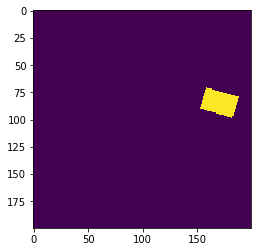

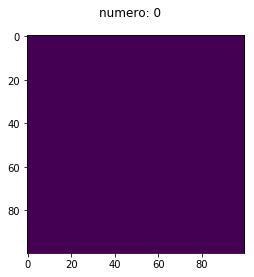

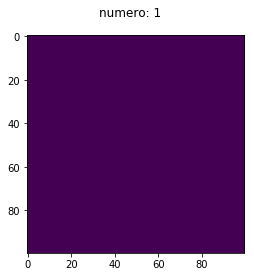

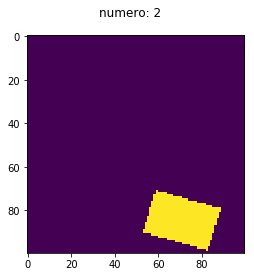

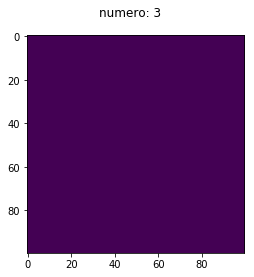

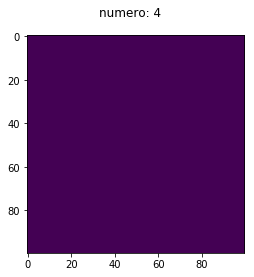

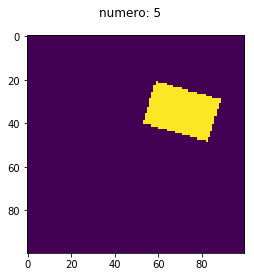

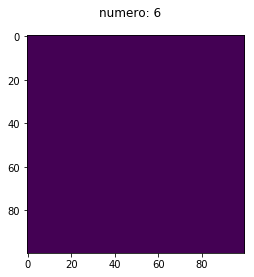

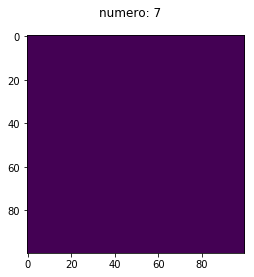

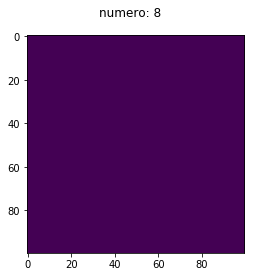

In [33]:
n = 1

imgSample = images[n]
crops, truths = makeCrops(imgSample, 50, (100,100), coords[n])
#print(len(labels))
print('!-- FOR N = ', n, ' y \n\t', [int(n) for n in labels[n]])
print('!-- y \n\t', [int(n) for n in truths])
print('!-- yhat \n\t', [int(o) for o in outputs[n]])
print('!-- x,y center + orient: ', coords[n])

for n in range(5):
    print('!-- y \t', [int(n) for n in labels[n]], 
          '\t y^: ', [int(o) for o in outputs[n]], 
          '\t loss: %.5f' % (criterion(outputs[n], labels[n].to(device))))

plt.imshow(imgSample)

for (i, crop) in enumerate(crops):
    #print("1-index number of window: ", i+1, 'x', x, 'y', y, 'has rectangle?', hasRect)
    plt.figure()
    plt.suptitle('numero: %d' % (i))
    plt.imshow(crop)
    
    
print('sum labels: %s, sum y^ labels: %s' % (np.sum(outputs.cpu().numpy()), 
    np.sum(labels.cpu().numpy())))

In [ ]:
n_total = len(test_loader.dataset)

print(n_total)
from IPython.display import display # to display images

import torchvision
img = torchvision.transforms.ToPILImage()(images[0].cpu())
display(img)

avg_err = total_err / n_total 
print(total_err)
print(avg_err)
xerr, yerr, orienterr = avg_err
print('\n ----------------------------')
print('Across a total of %d images, the average error was %0.2f and %0.2f pixels for x and y, \
and %0.2f degrees for orientation' % (n_total, xerr, yerr, math.degrees(orienterr)))
print('\n ----------------------------')

# diagnostics

In [ ]:
from IPython.display import display # to display images
#font = ImageFont.truetype("Arial.ttf",14) # OSError: cannot open resource
font = ImageFont.truetype("/usr/share/fonts/dejavu/DejaVuSans.ttf",14)
def imshow_coord(img, a_label):
    img = torchvision.transforms.ToPILImage()(img)
    draw = ImageDraw.Draw(img)
    #draw.text((10, 25), '(' + np.array2string(np.around(a_label.numpy()), separator=', ') + ')')
    x,y,orient = a_label
    rect_vertices = makeRectangle(5, 15, orient, offset=(x,y))
    draw.polygon(rect_vertices, fill='red')
    draw = draw_crosspointer(a_label, draw, 'green', 'white', length=8)
    display(img)
    
def draw_crosspointer(xy, draw, fillcolor_X='green', fillcolor='white', length=2):
    a,b, orient = tuple(xy)
    draw.line((a-length, b+length, a+length, b-length), fill=fillcolor_X)
    draw.line((a-length, b-length, a+length, b+length), fill=fillcolor_X)
    draw.point((a,b))
    return draw

In [ ]:
import torchvision 
import matplotlib.pyplot as plt
import copy
# get some random training images
with torch.no_grad():
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    outputs = model(images)
    
    # show images
    #imshow_coord(torchvision.utils.make_grid(images), (outputs))


    # print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  # for j in range(4)))
        
    loss = criterion(outputs.to(device), labels.to(device))
 
n =0 
#print(len(labels))
print('x,y truth', labels[n])
print('x,y guess by net', outputs[n])

images_copy = copy.deepcopy(images)
print('image size: ', images_copy[n].size())
print(loss)
print('net output: ')
imshow_coord(images_copy[n], outputs[n])
print('truth label: ')
imshow_coord(images_copy[n], labels[n])

#imagePIL = torchvision.transforms.ToPILImage()(images[n])
#print('PIL image size', imagePIL.size)
#imagePIL.save('test.png')
#display(imagePIL)

#display(Image.open('./data/rect'+str(n)+'.png'))

In [ ]:
%matplotlib inline
#im = Image.open("Mew.jpg")
n = 12
n = np.random.rand()*len(images)
n = int(n)

image = io.imread('./data/rect'+str(n)+'.png')
image_tensor = torch.FloatTensor(image).permute(2, 0, 1) #PIL and torch expect difft orders
coords = torch.FloatTensor(true_coords[n])
with torch.no_grad():
    output = model(image_tensor)

print(true_coords[n])
print(output)
x,y,orient = output.cpu().numpy().flatten()
imshow_coord(image, (x,y, orient))
plt.imshow(image)

In [ ]:
#img = Image.new('RGB', (300,400), 'gray')
import seaborn as sns
sns.set_style("ticks")
n = 0
#imshow_coord(images[n], outputs[n], labels[n])

print(images.size())
a = torchvision.utils.make_grid(images)
print(a.max(), a.min(), a.size())
#a = a / 2 + 0.5     # unnormalize

a = a.cpu().numpy()
a = np.transpose(a,(1,2,0))
print(a.shape)
print(a.ndim)

#ran = a.max() - a.min()
#a = (a/ran )

fig,ax = plt.subplots(1)
# Display the image
ax.imshow(a)
#x,y = labels[0].numpy()
#plt.scatter(x,y, color='g', marker='x', linewidth='1')
labels = labels.cpu()

plt.rcParams['figure.figsize'] = [30,5]
import matplotlib.patches as patches
for i in range(len(labels)):
    x,y, orient = labels[i].numpy()

# class matplotlib.patches.Rectangle(xy, width, height, angle=0.0, **kwargs)[source]

    rect = patches.Rectangle((x + i*IMG_X, y), 1,20,angle=orient, fill=True, color='orange')
    ax.add_patch(rect)
    ax.scatter(x + i*IMG_X, y, color='r', marker='x', linewidth='1')
#plt.imshow(np.transpose(a, (2,0,1)))

In [ ]:
import seaborn as sns
sns.set()
f = plt.subplot()
f.plot(range(len(losses_list)), losses_list)

plt.rcParams['figure.figsize'] = [30, 5]
xposition = np.array(range(num_epoch))  * (total_step)
#print(xposition)
for xc in xposition:
    #plt.axvline(x=xc, color='k', linestyle='--')
    pass

In [3]:
g = plt.subplot()
trunc = 100
g.plot(range(trunc), losses_list[-trunc:])

plt.show()

NameError: name 'plt' is not defined